# Functions and Requirements

In [1]:
%matplotlib notebook        
import os
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from camera import test_camera
from camera import take_picture
import numpy as np
from dlib_models import load_dlib_models
load_dlib_models()
from dlib_models import models
face_detect = models["face detect"]
face_rec_model = models["face rec"]
shape_predictor = models["shape predict"]

def numsfromrect(k):
    """
    Given a rectangle k will return x1,y1,x2,y2 of k
    """
    return list(map(int,str(k).replace('(','').replace('[','').replace(')','').replace(']','').replace(',','').split(' ')))

def box_faces(img):
    """
    Draws boxes around all faces in a pic.
    """
    k=face_detect(img)

    fig,ax = plt.subplots()
    ax.imshow(img)

    for i in range(len(k)):
        lst = numsfromrect(k[i])
        ax.add_patch(patches.Rectangle( (lst[0],lst[1]), lst[2]-lst[0], lst[3]-lst[1], fill=False))
        
def get_desc(img):
    """
    Get a single face description from a pic.
    Returns -1 if their is isn't exactly one face.
    
    Used for loading images and labels to avoid bad data.
    """
    k=face_detect(img)
    if len(k)!= 1:
        print("Wrong number of faces detected.")
        return -1
    shape=shape_predictor(img,k[0])
    descv = face_rec_model.compute_face_descriptor(img,shape)
    return np.array(descv)
def eucd(vect1,vect2):
    """
    Euclidian distance of two vectors.
    """
    return np.sqrt(((vect1-vect2)**2).sum())

def descriptions(img):
    """
    Given an image will return the list of descriptions of faces in it.
    """
    faces=face_detect(img)
    lst = []
    for k in faces:
        shape=shape_predictor(img,k)
        descv = face_rec_model.compute_face_descriptor(img,shape)
        lst.append(descv)
    return np.array(lst)
def loadDBimgs(dirt):
    """
    Loads a db from directory dirt.
    Dirt must be formated like such:
    Folders with names of the desired labels (ie: 'Daschel Cooper')
    Within them .jpg files.
    They will converted to numpy arrays when loaded.
        
    
    """
    lstOfDirs = [x[0] for x in os.walk(dirt)][1:]
    
    db = []
    
    for rootDir in lstOfDirs:
        print(rootDir)
        fileSet = set()

        

        for dir_, _, files in os.walk(rootDir):
            for fileName in files:
                relDir = os.path.relpath(dir_, rootDir)
                relFile = os.path.join(rootDir, fileName)
                if not fileName.startswith('.'):
                    fileSet.add(relFile)
        for file in fileSet:
            img_array = io.imread(file)
            name = rootDir.split('\\')[1]
            db.append((descriptions(img_array)[0], name))
    
    return db

def findMatch(d, db,conf=0.6):
    dists = []
    for i in db:
        dists.append(np.linalg.norm(d-i[0]))
    b = np.argmin(dists)
    print(np.min(dists))
    if(dists[b] < conf):
        return db[b][1]
    else:
        return "I don't know"
    
def label_faces(img,db):
    fig,ax = plt.subplots()
    ax.imshow(img)
    # Number of times to upscale image before detecting faces.
    # When would you want to increase this number?
    upscale = 1

    detections = face_detect(img, upscale)  # returns sequence of face-detections
    detections = list(detections)
    for det in detections:
        # bounding box dimensions for detection
        shape = shape_predictor(img, det)
        descriptor = (np.array(face_rec_model.compute_face_descriptor(img, shape)))
        text = findMatch(descriptor, db)
        lst = numsfromrect(det)
        ax.add_patch(patches.Rectangle( (lst[0],lst[1]), lst[2]-lst[0], lst[3]-lst[1], fill=False))
        ax.text(lst[0], lst[1], text, fontsize=10, color='white')

def saveDBnp(dirt,db):
    """
    Saves a db to directory dirt.
    """
    it = 0
    prevname = db[0][1]
    for entr in db:
        ray, name = entr[0],entr[1]
        if name != prevname:
            prevname = name
            it = 0
        direc = dirt + "\\" + name

        if not os.path.exists(direc):
            os.makedirs(direc)
            
        
        direc = direc + "\\vct" + str(it)
            
        np.savez(direc,ray=ray)
        it = it + 1
        
def loadDBnp(dirt):
    """
    Loads a db from directory dirt.
    Dirt must be formated like such:
    Folders with names of the desired labels (ie: 'Daschel Cooper')
    Within them .npz files storing arrays named 'ray'
        (this naming and format is done automatically by saveDBnp)
        
    
    """
    import skimage.io as io
    import os
    lstOfDirs = [x[0] for x in os.walk(dirt)][1:]
    
    db = []
    
    for rootDir in lstOfDirs:
        print(rootDir)
        fileSet = set()

        

        for dir_, _, files in os.walk(rootDir):
            for fileName in files:
                relDir = os.path.relpath(dir_, rootDir)
                relFile = os.path.join(rootDir, fileName)
                if not fileName.startswith('.'):
                    fileSet.add(relFile)
                    
        for file in fileSet:
            vector = np.load(file)['ray']
            name = rootDir.split('\\')[1]
            db.append( (vector , name) )
    
    return db

def addImgToDB(db,img,label):
    """
    Adds the face vector in img with label 'label' to
    db
    """
    desc = get_desc(img)
    if np.isscalar( desc ) == -1:
        print("error")
        return "early break"
    db.append( (desc,label) )
    return "success"



### Load Vectors

In [2]:
DB = loadDBnp("vectors")

vectors\Daschel Cooper
vectors\Matthew Callahan
vectors\Robin Williams
vectors\Tom Hanks


## Take and Label an Image

<IPython.core.display.Javascript object>


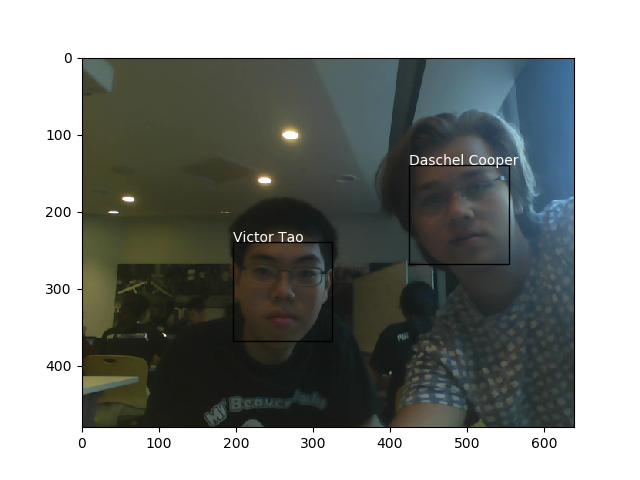

0.179301673738
0.393484738981


In [11]:
label_faces(take_picture(),DB)

### Take a picture
Save its vector and add it to DB

In [9]:
name = "Victor Tao"

addImgToDB(DB,take_picture(),name)
saveDBnp("vectors",DB)